In [1]:
%matplotlib notebook
#%matplotlib inline

import copy
import numpy as np
import random
import matplotlib.pyplot as plt
from _converter import SensorThings2Dict
from _evaluation import print_metrics

In [3]:
import json
files = ["ABU1.txt", "ABU1.2.txt"]
data = []
bad = 0
for filename in files:
    print("Loading rows... {}".format(filename))
    with open(filename) as f:
        for line in f:
            try:
                features = SensorThings2Dict(json.loads(line))
                data.append(list(features.values()))
            except Exception, e:
                bad+=1

print("Incomplete rows: {}".format(bad))
print("Loaded: {}".format(len(data)))

""" random split seed """
data = np.asarray(data)
#print(data[:,2:-1])
# numerics = data[:,2:-1]
# for n in numerics[data[:,-1]=='True']:
#     plt.plot(n);
mask = np.random.rand(len(data)) < 0.9

Loading rows... ABU1.txt
Loading rows... ABU1.2.txt
Incomplete rows: 357
Loaded: 83086


In [4]:
_false = "False"
_true = "True"

train = data[mask]
test = data[~mask]
faulty = train[train[:,-1]==_false]
not_faulty = train[train[:,-1]==_true]
fr = len(faulty)/float(len(train))
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(not_faulty), len(faulty), fr))
print("Test  Total: {} Good: {} Faulty: {} Ratio: {}".format(len(test), len(test[test[:,-1]==_true]), len(test[test[:,-1]==_false]), float(len(test[test[:,-1]==_false]))/len(train)))


print("Re-sampling...")
from scipy.stats import logistic

# Take random numbers from a logistic probability density function
def logistic_choice(total, sample_size, replace=False):
    p = logistic.pdf(np.arange(0,total), loc=0, scale=total/5)
    p /= np.sum(p)
    
    return np.random.choice(total, size=sample_size, replace=replace, p=p)

sample_size = np.min([5000, len(not_faulty)])
samples = logistic_choice(len(not_faulty), sample_size)
# TODO: Upsample faulties with logistic_choice(replace=True)
f_sample_size = np.min([1000, len(faulty)])
f_samples = logistic_choice(len(faulty), f_sample_size)
# Put samples together and shuffle
train = np.concatenate((not_faulty[samples], faulty[f_samples]))
train = np.random.permutation(train)

faulty = train[train[:,-1]==_false]
not_faulty = train[train[:,-1]==_true]
fr = len(faulty)/float(len(train))
print("Train Total: {} Good: {} Faulty: {} Ratio: {}".format(len(train), len(not_faulty), len(faulty), fr))

train_data = train[:,2:-1].astype(np.float32)
test_data = test[:,2:-1].astype(np.float32)
"""
Quality_OK is mapped to Faultiness
    'False' -> 1 (Faulty)
    'True'  -> 0 (Good)
"""
train_labels = np.array(train[:,-1]==_false).astype(np.int32)
test_labels = np.array(test[:,-1]==_false).astype(np.int32)

Train Total: 74787 Good: 70467 Faulty: 4320 Ratio: 0.0577640499017
Test  Total: 8299 Good: 7808 Faulty: 491 Ratio: 0.00656531215318
Re-sampling...
Train Total: 6000 Good: 5000 Faulty: 1000 Ratio: 0.166666666667


In [64]:
""" Classification and Regression Trees (CART) """
from sklearn.tree import DecisionTreeClassifier

criteria = ["gini", "entropy"]
clf = DecisionTreeClassifier(criterion=criteria[0], random_state=1, max_depth=100,  class_weight={0:1-fr, 1:fr})

%time t = clf.fit(train_data, train_labels)
print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

Wall time: 1.07 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5000
          1       1.00      0.99      0.99      1000

avg / total       1.00      1.00      1.00      6000

Confusion Matrix:


,0,1
0,5000,0
1,11,989


Matthews Correlation Coefficient: 0.993392659653
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8034
          1       0.93      0.97      0.95       494

avg / total       0.99      0.99      0.99      8528

Confusion Matrix:


,0,1
0,7995,39
1,13,481


Matthews Correlation Coefficient: 0.945830231996
--------------------------------------------------------------


In [5]:
""" Random Forest """
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100,  class_weight={0:1-fr, 1:fr}, max_depth=90, n_jobs=4)

%time clf = clf.fit(train_data, train_labels)
print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

pp = clf.predict(train_data)
print(pp)

Wall time: 4.41 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5000
          1       1.00      0.98      0.99      1000

avg / total       1.00      1.00      1.00      6000

Confusion Matrix:


,0,1
0,5000,0
1,18,982


Matthews Correlation Coefficient: 0.989180206569
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      7808
          1       0.93      0.96      0.94       491

avg / total       0.99      0.99      0.99      8299

Confusion Matrix:


,0,1
0,7770,38
1,21,470


Matthews Correlation Coefficient: 0.937313472032
--------------------------------------------------------------
[0 0 1 ..., 0 0 0]


In [74]:
""" Gradient Boosting """
from sklearn.ensemble import GradientBoostingClassifier

losses = ['deviance', 'exponential']
clf = GradientBoostingClassifier(loss=losses[1], n_estimators=100,  max_depth=90, learning_rate=0.1)

%time clf = clf.fit(train_data, train_labels)
print_metrics(train_labels, clf.predict(train_data))
print_metrics(test_labels, clf.predict(test_data))

Wall time: 26.7 s
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5000
          1       1.00      1.00      1.00      1000

avg / total       1.00      1.00      1.00      6000

Confusion Matrix:


,0,1
0,5000,0
1,0,1000


Matthews Correlation Coefficient: 1.0
--------------------------------------------------------------
------------------------- EVALUATION -------------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00      8034
          1       0.92      1.00      0.96       494

avg / total       1.00      0.99      0.99      8528

Confusion Matrix:


,0,1
0,7991,43
1,2,492


Matthews Correlation Coefficient: 0.954323345011
--------------------------------------------------------------


<IPython.core.display.Javascript object>


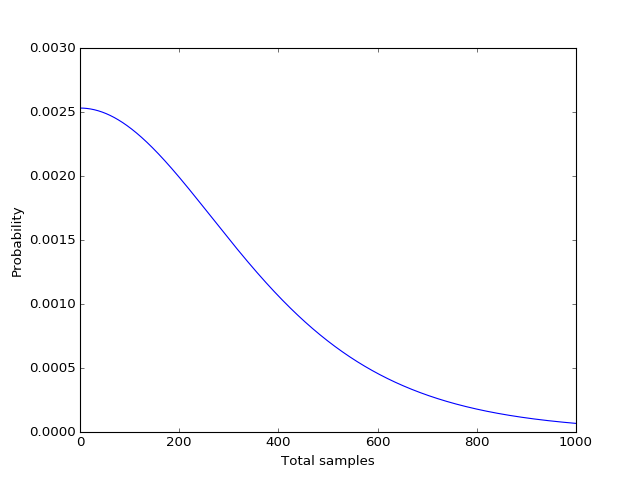

In [36]:
from scipy.stats import logistic

# from scipy.stats import poisson
# p = poisson.sf(np.arange(0,100),80, loc=-20)
# plt.plot(p)

total = 1000
p = logistic.pdf(np.arange(0,total), loc=0, scale=total/5.0)
# p -= np.min(p)
# p /= np.max(p)
p /= np.sum(p)
plt.plot(p)
plt.ylabel("Probability")
plt.xlabel("Total samples")


# s = np.random.choice(total, size=500, replace=False, p=p)
# x = np.zeros(1000)
# for i in s:
#     x[i] = 1
# plt.plot(x, 'ro')

In [18]:
from collections import deque

d = deque([], maxlen=5)


d.append(np.asarray([1,2,3]))
print(d)
d.append(np.asarray([10,11,12]))
print(np.asarray(d))

deque([array([1, 2, 3])], maxlen=5)
[[ 1  2  3]
 [10 11 12]]
